# dog vs cat with transfer learning

## dependencies

In [29]:
from zipfile import ZipFile
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import glob
import cv2
import tensorflow as tf
import tensorflow_hub as hub

## dataset

In [2]:
# configuration
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# downloading the dataset
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:04<00:00, 131MB/s]
100% 812M/812M [00:04<00:00, 207MB/s]


In [4]:
!ls

dogs-vs-cats.zip  kaggle.json  sample_data


In [5]:
# extracting the entire dataset
ds = "/content/dogs-vs-cats.zip"

with ZipFile(ds, "r") as zip:
  zip.extractall()
  print("extraction complete...............")

extraction complete...............


In [6]:
# extracting the entire dataset
trainds = "/content/train.zip"

with ZipFile(trainds, "r") as zip:
  zip.extractall()
  print("extraction complete...............")

extraction complete...............


In [7]:
path, dirs, files = next(os.walk("/content/train"))
file_count = len(files)
print("number of images:", file_count)

number of images: 25000


## dataset exploration

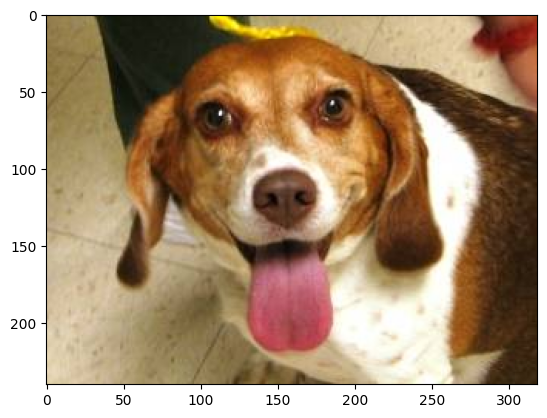

In [8]:
# displaying dog image
img = mpimg.imread("/content/train/dog.12365.jpg")
img_plt = plt.imshow(img)
plt.show()


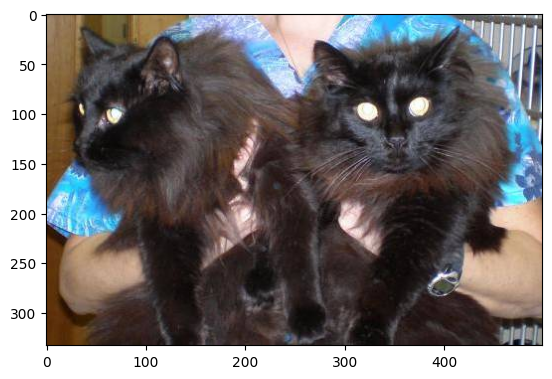

In [9]:
# displaying dog image
img = mpimg.imread("/content/train/cat.960.jpg")
img_plt = plt.imshow(img)
plt.show()

## images preprocessing

In [10]:
file_names = os.listdir("/content/train/")

for i in range(5):
  name = file_names[i]
  print(name[:3])

cat
dog
cat
cat
dog


In [11]:
file_names = os.listdir("/content/train/")
dog_count = 0
cat_count = 0

for img_file in file_names:
  name = img_file[0:3]
  if name == "dog":
    dog_count += 1
  else:
    cat_count += 1
print("dogs: ", dog_count)
print("cats: ", cat_count)

dogs:  12500
cats:  12500


In [12]:
# directory for resized images
os.mkdir("/content/image_resized")

In [13]:
original_folder = "/content/train/"
resized_folder = "/content/image_resized/"

# 2000 images only
for i in range(2000):
  filename = os.listdir(original_folder)[i]
  img_path = original_folder+filename

  img = Image.open(img_path)
  img = img.resize((224, 224))
  img = img.convert("RGB")

  newImgPath = resized_folder+filename
  img.save(newImgPath)

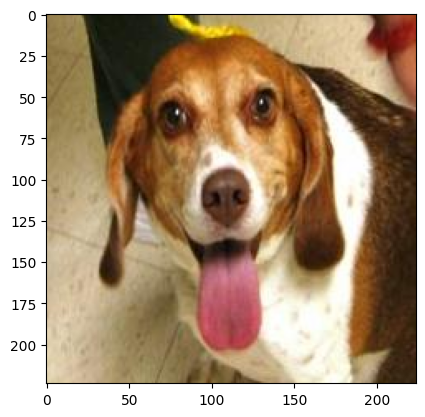

In [14]:
# displaying dog resized image
img = mpimg.imread("/content/image_resized/dog.12365.jpg")
img_plt = plt.imshow(img)
plt.show()

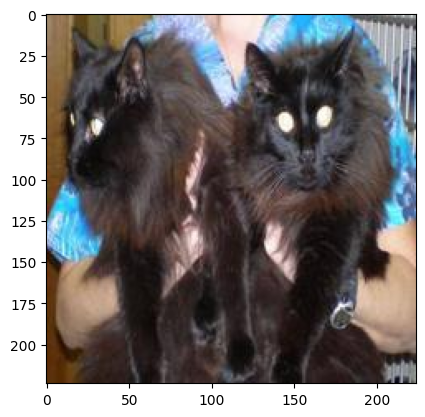

In [15]:
# displaying cat resized image
img = mpimg.imread("/content/image_resized/cat.960.jpg")
img_plt = plt.imshow(img)
plt.show()

In [16]:
# assigning labels (cat --> 0, dog --> 1)
file_names = os.listdir("/content/image_resized/")
labels = []

for i in range(2000):
  file_name = file_names[i]
  label = file_name[0:3]

  if label == "dog":
    labels.append(1)
  else:
    labels.append(0)


In [17]:
print(len(labels[:10]))
print(labels[:10])

10
[0, 1, 0, 0, 1, 1, 1, 0, 1, 1]


In [18]:
# images distribution in the sample
values, counts = np.unique(labels, return_counts=True)
print(values)
print(counts)

[0 1]
[ 989 1011]


In [20]:
# to np arrays
image_directory = "/content/image_resized/"
image_extension = ["png", "jpg"]

files = []
[files.extend(glob.glob(image_directory + "*." + e)) for e in image_extension]
dog_cat_images = np.asarray([cv2.imread(file) for file in files])

In [22]:
print(dog_cat_images.shape)

(2000, 224, 224, 3)


## features and labels selection, modelling, and training

In [23]:
# images and labels
X, y = dog_cat_images, np.asarray(labels)
y.shape

(2000,)

In [25]:
# training and testing splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 21
)
print(X.shape, X_train.shape, X_test.shape)

(2000, 224, 224, 3) (1600, 224, 224, 3) (400, 224, 224, 3)


In [26]:
# scaling the images
X_train_scaled = X_train/255
X_test_scaled = X_test/255

## transfer learning modelling --> mobilenetv2